In [1]:
#!pip install torchmetrics
import pandas as pd
import numpy as np
import torch
from torch import nn
import torchmetrics
import seaborn as sns
import matplotlib.pyplot as plt
from torchmetrics import Accuracy, ConfusionMatrix
from sklearn.datasets import load_breast_cancer
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"{torch.__version__}, running on {device}")

2.1.0+cu121, running on cpu


In [2]:
cancer = load_breast_cancer()
df = pd.DataFrame(np.c_[cancer['data'], cancer['target']],
                  columns= np.append(cancer['feature_names'], ['target']))
df

df.corr()['target']


mean radius               -0.730029
mean texture              -0.415185
mean perimeter            -0.742636
mean area                 -0.708984
mean smoothness           -0.358560
mean compactness          -0.596534
mean concavity            -0.696360
mean concave points       -0.776614
mean symmetry             -0.330499
mean fractal dimension     0.012838
radius error              -0.567134
texture error              0.008303
perimeter error           -0.556141
area error                -0.548236
smoothness error           0.067016
compactness error         -0.292999
concavity error           -0.253730
concave points error      -0.408042
symmetry error             0.006522
fractal dimension error   -0.077972
worst radius              -0.776454
worst texture             -0.456903
worst perimeter           -0.782914
worst area                -0.733825
worst smoothness          -0.421465
worst compactness         -0.590998
worst concavity           -0.659610
worst concave points      -0

In [3]:
#select features
#indices_to_del=[1, 4, 5, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 21, 24, 25, 28, 29]
#indices_to_del=[1, 4, 8, 9, 11, 14, 15, 16, 17, 18, 19, 21, 24, 28, 29]

X=cancer.data

y=cancer.target
#X = np.delete(X, indices_to_del, axis=1)  # Remove columns with specified indices
X=torch.from_numpy(X).type(torch.float32)
y=torch.from_numpy(y).type(torch.float32)
X.shape, y.shape
INPUTS_ALL = X.shape[1]
print(INPUTS_ALL)

30


In [4]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [5]:
# #ONLY RUN THESE CELLS FOR NON PYTORCH TRAINING OF MODEL AND COMMENT OUT numpy->torch above

# from sklearn.linear_model import LogisticRegression

# # Create a Logistic Regression model
# model = LogisticRegression()

# # Train the model
# model.fit(X_train, y_train)

In [6]:
# from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# # Predict on the test set
# y_pred = model.predict(X_test)

# # Calculate accuracy
# accuracy = accuracy_score(y_test, y_pred)
# print(f"Accuracy: {accuracy}")

# # Other evaluation metrics
# print(classification_report(y_test, y_pred))

# # Confusion matrix
# conf_matrix = confusion_matrix(y_test, y_pred)
# print("Confusion Matrix:")
# print(conf_matrix)


In [7]:
#train test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

X_train.to(device)
X_test.to(device)
y_train.to(device)
y_test.to(device)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([381, 30]),
 torch.Size([188, 30]),
 torch.Size([381]),
 torch.Size([188]))

In [8]:
#define our model

class CancerPredictionModel(nn.Module):
  def __init__(self, in_features, hidden_neurons):
    super().__init__()
    self.layer1=nn.Linear(in_features=in_features, out_features=hidden_neurons)
    self.layer2=nn.Linear(in_features=hidden_neurons, out_features=hidden_neurons)
    self.layer3=nn.Linear(in_features=hidden_neurons, out_features=1)
    self.sigmoid=nn.Sigmoid()
  def forward(self, x: torch.Tensor)->torch.Tensor:
    return self.sigmoid(self.layer3(self.sigmoid(self.layer2(self.sigmoid(self.layer1(x))))))

breast_cancer_model = CancerPredictionModel(in_features=INPUTS_ALL, hidden_neurons=64).to(device)

In [9]:
#define loss function, accuracy function, and optimizer

loss_func = nn.BCELoss()

optimizer = torch.optim.SGD(params=breast_cancer_model.parameters(), lr=0.008)

def accuracy(y_test, y_preds):
  correct=torch.eq(y_test, y_preds).sum().item()
  return (correct/len(y_preds)) * 100


In [10]:
#train our model
torch.manual_seed(42)
epochs=9779
epochs_arr = []
train_loss_arr = []
test_loss_arr = []
train_acc_arr = []
test_acc_arr = []
patience = 1000  # Number of epochs to wait for improvement
best_test_loss = np.inf  # Initializing with a large value
counter = 0  # Counter to track epochs without improvement
best_model_state = None  # To store the best model's state

for epoch in range(epochs):
  breast_cancer_model.train()
  y_preds = (breast_cancer_model(X_train)).squeeze()

  loss=loss_func(y_preds, y_train)
  acc=torchmetrics.Accuracy(task='binary')
  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  breast_cancer_model.eval()

  with torch.inference_mode():
    test_preds = (breast_cancer_model(X_test)).squeeze()
    test_loss = loss_func(test_preds, y_test)
    test_acc = torchmetrics.Accuracy(task='binary')
  epochs_arr.append(epoch)
  train_loss_arr.append(loss.detach().numpy())
  test_loss_arr.append(test_loss.detach().numpy())
  train_acc_arr.append(acc(y_preds, y_train).detach().numpy())
  test_acc_arr.append(test_acc(test_preds, y_test).detach().numpy())
  if(epoch%100==0):
     print(f"Epoch {epoch} -- Training Accuracy: {acc(y_preds, y_train)}, Testing Accuracy: {test_acc(test_preds, y_test)}, Training Loss: {loss}, Testing Loss: {test_loss}")
  # Early stopping check
  if test_acc < best_test_loss:
      best_test_loss = test_acc
      counter = 0
      # Update the best model state
      best_model_state = breast_cancer_model.state_dict()
  else:
      counter += 1
      if counter >= patience:
         print(f"Early stopping at epoch {epoch}.")
         break

# If early stopping occurred, load the best model state
if best_model_state is not None:
    breast_cancer_model.load_state_dict(best_model_state)

Epoch 0 -- Training Accuracy: 0.38057741522789, Testing Accuracy: 0.35638296604156494, Training Loss: 0.7326962351799011, Testing Loss: 0.7333889603614807
Epoch 100 -- Training Accuracy: 0.6194225549697876, Testing Accuracy: 0.6436170339584351, Training Loss: 0.6587244272232056, Testing Loss: 0.6466946005821228
Epoch 200 -- Training Accuracy: 0.6194225549697876, Testing Accuracy: 0.6436170339584351, Training Loss: 0.655565619468689, Testing Loss: 0.6426769495010376
Epoch 300 -- Training Accuracy: 0.6194225549697876, Testing Accuracy: 0.6436170339584351, Training Loss: 0.6526442766189575, Testing Loss: 0.6393625140190125
Epoch 400 -- Training Accuracy: 0.6194225549697876, Testing Accuracy: 0.6436170339584351, Training Loss: 0.6495225429534912, Testing Loss: 0.6358228921890259
Epoch 500 -- Training Accuracy: 0.6194225549697876, Testing Accuracy: 0.6436170339584351, Training Loss: 0.6460732817649841, Testing Loss: 0.6319660544395447
Epoch 600 -- Training Accuracy: 0.6194225549697876, Test

Min training loss: 0.1937439888715744, Epoch # 9004
Min testing loss: 0.11106587201356888, Epoch # 9295
Max training accuracy: 0.93438321352005, Epoch # 9153
Max testing accuracy: 0.9734042286872864, Epoch # 5206


(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='Predicted class', ylabel='True class'>)

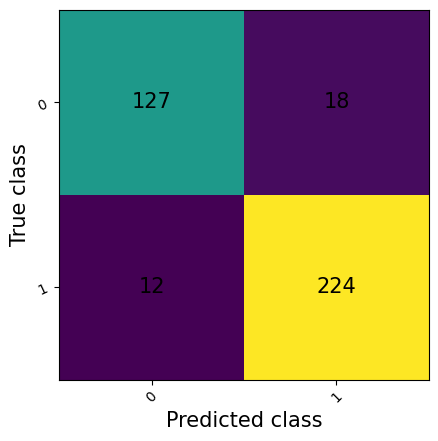

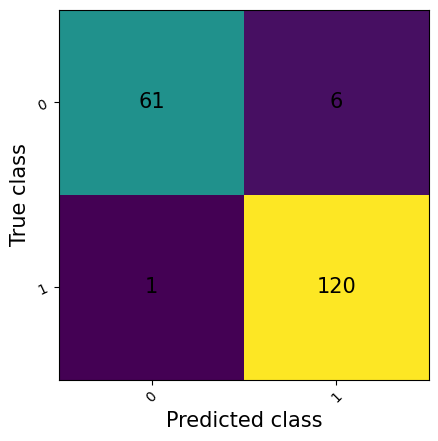

In [11]:
min_trainloss=np.argmin(train_loss_arr)
epoch_min_trainloss=epochs_arr[min_trainloss]

min_testloss=np.argmin(test_loss_arr)
epoch_min_testloss=epochs_arr[min_testloss]

max_trainacc=np.argmax(train_acc_arr)
epoch_max_trainacc=epochs_arr[max_trainacc]

max_testacc=np.argmax(test_acc_arr)
epoch_max_testacc=epochs_arr[max_testacc]

#choose a metric preference - optimal loss and accuracy params, epoch # @ these
print(f"Min training loss: {np.min(train_loss_arr)}, Epoch # {epoch_min_trainloss}")
print(f"Min testing loss: {np.min(test_loss_arr)}, Epoch # {epoch_min_testloss}")
print(f"Max training accuracy: {np.max(train_acc_arr)}, Epoch # {epoch_max_trainacc}")
print(f"Max testing accuracy: {np.max(test_acc_arr)}, Epoch # {epoch_max_testacc}")

cf_train=torchmetrics.ConfusionMatrix(task='binary')
cf_train(y_preds, y_train)
print("Training Data")
cf_train.plot()
cf_test=torchmetrics.ConfusionMatrix(task='binary')
cf_test(test_preds, y_test)
print("Testing Data")
cf_test.plot()

#conclusion: if we eliminate variables that do not have a high correlation with targets, we can use less neurons and layers thus reducing computational resources to gain nearly as accurate predictions as original data with more neurons and layers
#with 20,000 epochs, we get the following results (increase epochs to decrease loss):
#~94% training accuracy, ~97.5% testing accuracy, ~0.1 testing loss with low corr variables eliminated, 1 hidden layer, 64 neurons, lr=0.008
#for consistent results and growth of accuracy/decrease of loss, use smaller learning rate with more epochs
#~94.3% training accuracy, ~98% testing accuracy, ~0.095 testing loss with all original data, 2 hidden layers, 64 neurons, lr=0.01
#~94.5% training accuracy, ~97.3% testing accuracy, ~0.090 testing loss with all original data, 1 hidden layer, 64 neurons, lr=0.01
